# DMGs for hypoxia and control treatments 
All the oysters included in this analysis have experienced hypoxia or control treatments for either phase 1 and/or phase 2. No other treatments (both, warm) are included in this analysis.

Counts matrix was generated with `GTF.featureType="gene"` 

differs from original, where it was counting methylation happening in exon features (`GTF.featureType="exon"`) and then binned into meta-features (genes)

#### 11/12/2024
futher investigating DESeq results based on notes from SGW 

first, loading in the dataframes originally generated in deseq_analysis.ipynb that are needed for DESeq
- these would include the counts matrix and meta data

In [2]:
# loading required packages
library(tidyverse)
library(DESeq2)
library(EnhancedVolcano)
library(dplyr)
library(ggh4x)
library(cowplot)
library(vegan)

In [3]:
counts <- read.csv('/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_MethylRAD_analysis_2018/analysis/counts_and_meta/geneFeature_counts.txt', sep='\t')
head(counts)

,GeneID,Length,X2018..BBB.WBO.B21.CV_sorted.bam,X2018..BBB.WBV.B70.CV_sorted.bam,X2018..BBO.BBO.B16.CV_sorted.bam,X2018..BBO.BBY.B27.CV_sorted.bam,X2018..BBO.WBO.B16.CV_sorted.bam,X2018..BBO.WBV.B64.CV_sorted.bam,X2018..BBR.BBB.B50.CV_sorted.bam,X2018..BBR.BBG.B38.CV_sorted.bam,⋯,X2018..WBR.BBY.W25.CV_sorted.bam,X2018..WBV.WBO.W23.CV_sorted.bam,X2018..WBV.WBR.W12.CV_sorted.bam,X2018..WBY.BBV.W65.CV_sorted.bam,X2018..WBY.BBY.W30.CV_sorted.bam,X2018..WPB.BPG.G45.CV_sorted.bam,X2018..WPO.BPO.G16.CV_sorted.bam,X2018..WPO.BPY.G28.CV_sorted.bam,X2018..WPR.BPY.G25.CV_sorted.bam,X2018..WPV.BPR.G11.CV_sorted.bam
,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,LOC111116054,1017,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
2,LOC111126949,4364,0,0,0,0,0,1,0,0,⋯,0,0,0,0,0,0,0,0,0,0
3,LOC111110729,23787,0,0,0,0,0,0,1,0,⋯,1,0,0,1,0,0,0,0,0,0
4,LOC111112434,9649,4,6,0,0,3,2,0,0,⋯,0,3,0,0,5,2,0,1,0,0
5,LOC111120752,6621,7,2,1,0,3,0,0,0,⋯,0,1,0,0,1,0,0,1,1,0
6,LOC111128944,1773,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


In [4]:
# removing the extra info from the file name
cleaned_column_names <- gsub("^X2018\\.\\.", "", gsub("\\.CV_sorted\\.bam$", "", colnames(counts)))
head(cleaned_column_names)

# replace the '.' with '-'
cleaned_column_names2 <- gsub('\\.', "-", cleaned_column_names)
head(cleaned_column_names2)

# now assigning to the columns
colnames(counts) = cleaned_column_names2
head(counts)

[1] "GeneID"      "Length"      "BBB.WBO.B21" "BBB.WBV.B70" "BBO.BBO.B16"
[6] "BBO.BBY.B27"

[1] "GeneID"      "Length"      "BBB-WBO-B21" "BBB-WBV-B70" "BBO-BBO-B16"
[6] "BBO-BBY-B27"

,GeneID,Length,BBB-WBO-B21,BBB-WBV-B70,BBO-BBO-B16,BBO-BBY-B27,BBO-WBO-B16,BBO-WBV-B64,BBR-BBB-B50,BBR-BBG-B38,⋯,WBR-BBY-W25,WBV-WBO-W23,WBV-WBR-W12,WBY-BBV-W65,WBY-BBY-W30,WPB-BPG-G45,WPO-BPO-G16,WPO-BPY-G28,WPR-BPY-G25,WPV-BPR-G11
,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,LOC111116054,1017,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
2,LOC111126949,4364,0,0,0,0,0,1,0,0,⋯,0,0,0,0,0,0,0,0,0,0
3,LOC111110729,23787,0,0,0,0,0,0,1,0,⋯,1,0,0,1,0,0,0,0,0,0
4,LOC111112434,9649,4,6,0,0,3,2,0,0,⋯,0,3,0,0,5,2,0,1,0,0
5,LOC111120752,6621,7,2,1,0,3,0,0,0,⋯,0,1,0,0,1,0,0,1,1,0
6,LOC111128944,1773,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


In [5]:
# setting the gene name as the row name and deleting that column
rownames(counts) <- counts$GeneID
counts2 <- counts[-1]
counts2 <- counts2[-1]

head(counts2)

,BBB-WBO-B21,BBB-WBV-B70,BBO-BBO-B16,BBO-BBY-B27,BBO-WBO-B16,BBO-WBV-B64,BBR-BBB-B50,BBR-BBG-B38,BBR-BBY-B26,BBY-WBG-B42,⋯,WBR-BBY-W25,WBV-WBO-W23,WBV-WBR-W12,WBY-BBV-W65,WBY-BBY-W30,WPB-BPG-G45,WPO-BPO-G16,WPO-BPY-G28,WPR-BPY-G25,WPV-BPR-G11
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
LOC111116054,0,0,0,0,0,0,0,0,1,0,⋯,0,0,0,0,0,0,0,0,0,0
LOC111126949,0,0,0,0,0,1,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
LOC111110729,0,0,0,0,0,0,1,0,0,0,⋯,1,0,0,1,0,0,0,0,0,0
LOC111112434,4,6,0,0,3,2,0,0,1,1,⋯,0,3,0,0,5,2,0,1,0,0
LOC111120752,7,2,1,0,3,0,0,0,1,0,⋯,0,1,0,0,1,0,0,1,1,0
LOC111128944,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


In [6]:
meta <- read.csv('/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_MethylRAD_analysis_2018/analysis/counts_and_meta/CV_CE18_meta.csv')

# changing rownames to the unique sample ID
rownames(meta) <- meta$unique_ID

meta$treatment <- paste(meta$Phase1, meta$Phase2, sep = "_")

# pulling out only the rows I need
meta <- select(meta, Phase1, Phase2, treatment)
head(meta)

,Phase1,Phase2,treatment
,<chr>,<chr>,<chr>
BBB-WBO-B21,hypoxic,control,hypoxic_control
BBB-WBV-B70,hypoxic,control,hypoxic_control
BBO-BBO-B16,hypoxic,hypoxic,hypoxic_hypoxic
BBO-BBY-B27,hypoxic,hypoxic,hypoxic_hypoxic
BBO-WBO-B16,hypoxic,control,hypoxic_control
BBO-WBV-B64,hypoxic,control,hypoxic_control


In [7]:
# setting the same order for counts matrix and meta data
counts2 <- counts2[,rownames(meta)]
all(rownames(meta) == colnames(counts2))

[1] TRUE

now ready for analysis

## Making *all* pairwise comparisons
we want to look at all pairwise comparisons, just to get the full picture..

these include:
- control control vs. hypoxic hypoxic
- hypoxic control vs. control hypoxic

In [8]:
# removing warm both and both both samples
meta_filtered <- filter(meta, meta$Phase2 != 'both')

# need to remove them from counts as well
counts_filtered <- counts2[, colnames(counts2) %in% rownames(meta_filtered)]

dim(meta_filtered)
dim(counts_filtered)

[1] 20  3

[1] 39505    20

In [9]:
# creating DESeq2 objext from the matrix, with the design = treatment (which has both phase 1 and phase 2 variables)
dds <- DESeqDataSetFromMatrix(countData = counts_filtered,
                              colData = meta_filtered, 
                              design = ~ treatment)
dds=DESeq(dds)
resultsNames(dds)

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”
estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



[1] "Intercept"                                   
[2] "treatment_control_hypoxic_vs_control_control"
[3] "treatment_hypoxic_control_vs_control_control"
[4] "treatment_hypoxic_hypoxic_vs_control_control"

### control control vs. hypoxic hypoxic
CC vs. HH

using 'normal' for LFC shrinkage, the Normal prior from Love et al (2014).

Note that type='apeglm' and type='ashr' have shown to have less bias than type='normal'.
See ?lfcShrink for more details on shrinkage type, and the DESeq2 vignette.
Reference: https://doi.org/10.1093/bioinformatics/bty895




out of 24636 with nonzero total read count
adjusted p-value < 0.1
LFC > 0.25 (up)    : 1, 0.0041%
LFC < -0.25 (down) : 1, 0.0041%
outliers [1]       : 321, 1.3%
low counts [2]     : 0, 0%
(mean count < 5)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



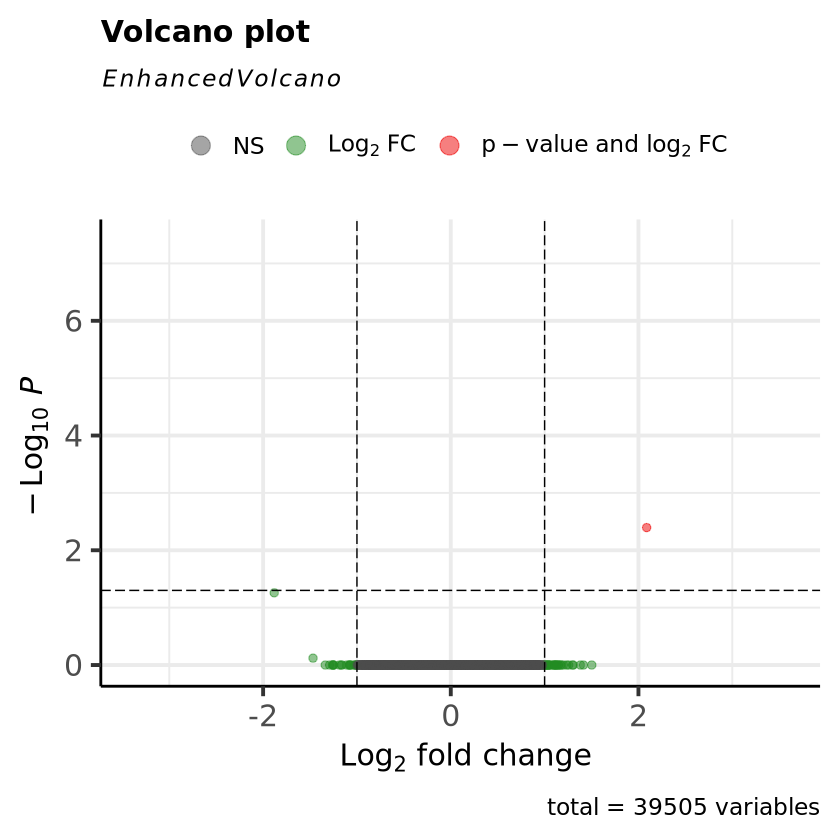

In [11]:
# control control vs. hypoxic hypoxic

contrast2 <- c("treatment", "hypoxic_hypoxic", "control_control")

# results of contrast1 with lfcThreshold=0.25 and normal shrinkage estimator
ls<-lfcShrink(dds, # dds object
                      contrast = contrast2, # only coef or contrast can be specified
                      type="normal", lfcThreshold=0.25,
                      cooksCutoff=FALSE, independentFiltering=FALSE) # adding stuff to change outliers/padj=NA
summary(ls)

EnhancedVolcano(ls, 
                lab=NA,
                x = 'log2FoldChange',
                y='padj',
                pCutoff=0.05)

1 DMGs for control control

1 DMGs for hypoxic hypoxic

In [12]:
write.csv(as.data.frame(ls), "/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_MethylRAD_analysis_2018/analysis/deseq_res_files/geneFeatures_res/CC_vs_HH.csv")

### hypoxic control vs. control control
HC vs. CC

using 'normal' for LFC shrinkage, the Normal prior from Love et al (2014).

Note that type='apeglm' and type='ashr' have shown to have less bias than type='normal'.
See ?lfcShrink for more details on shrinkage type, and the DESeq2 vignette.
Reference: https://doi.org/10.1093/bioinformatics/bty895




out of 24636 with nonzero total read count
adjusted p-value < 0.1
LFC > 0.25 (up)    : 3, 0.012%
LFC < -0.25 (down) : 20, 0.081%
outliers [1]       : 321, 1.3%
low counts [2]     : 16798, 68%
(mean count < 3)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



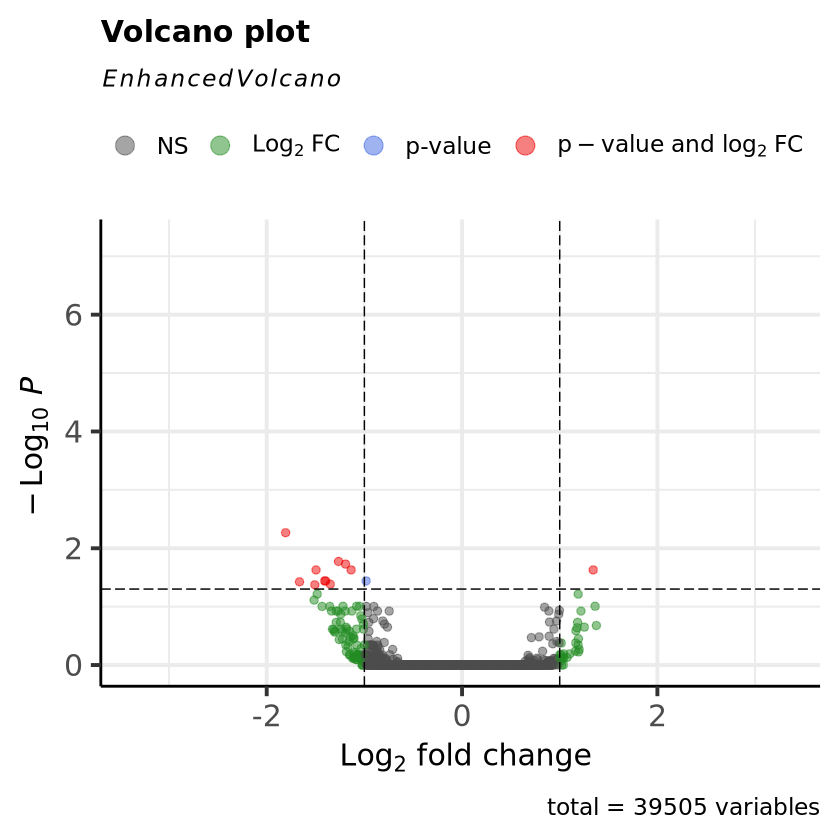

In [13]:
# hypoxic control vs. control control

contrast3 <- c("treatment", "hypoxic_control", "control_control")

# results of contrast1 with lfcThreshold=0.25 and normal shrinkage estimator
ls2<-lfcShrink(dds, # dds object
                      contrast = contrast3, # only coef or contrast can be specified
                      type="normal", lfcThreshold=0.25,
                      cooksCutoff=FALSE, independentFiltering=FALSE) # adding stuff to change outliers/padj=NA
summary(ls2)

EnhancedVolcano(ls2, 
                lab=NA,
                x = 'log2FoldChange',
                y='padj',
                pCutoff=0.05)

3 DMGs for hypoxic control

20 DMGs for control control

In [14]:
write.csv(as.data.frame(ls2), "/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_MethylRAD_analysis_2018/analysis/deseq_res_files/geneFeatures_res/CC_vs_HC.csv")

### control hypoxic vs. control control
CH vs. CC

using 'normal' for LFC shrinkage, the Normal prior from Love et al (2014).

Note that type='apeglm' and type='ashr' have shown to have less bias than type='normal'.
See ?lfcShrink for more details on shrinkage type, and the DESeq2 vignette.
Reference: https://doi.org/10.1093/bioinformatics/bty895




out of 24636 with nonzero total read count
adjusted p-value < 0.1
LFC > 0.25 (up)    : 1, 0.0041%
LFC < -0.25 (down) : 0, 0%
outliers [1]       : 321, 1.3%
low counts [2]     : 0, 0%
(mean count < 3)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



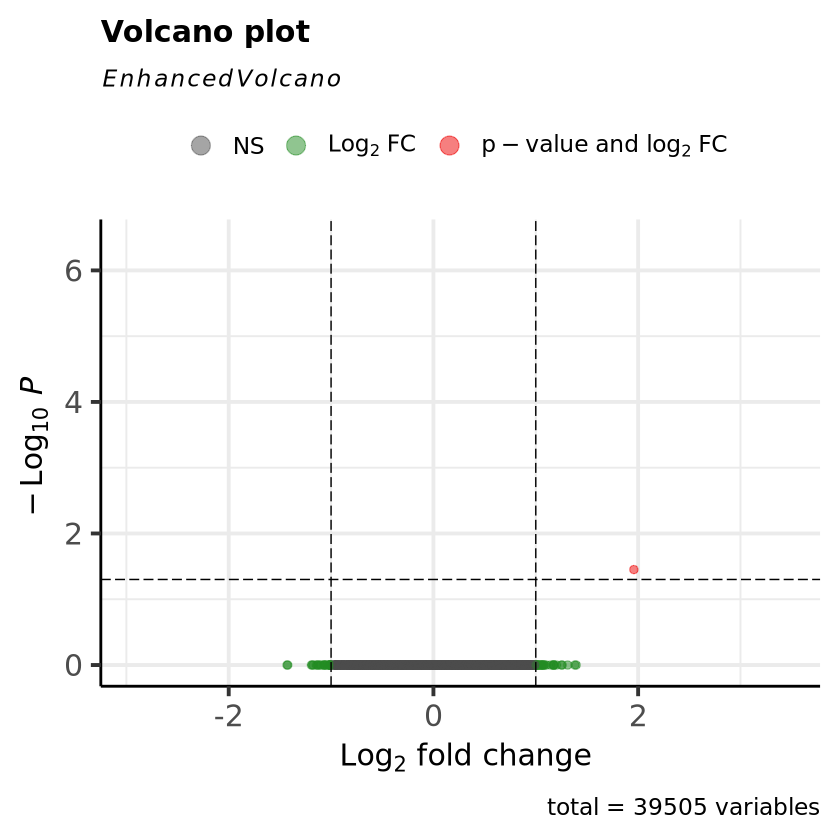

In [15]:
# control hypoxic vs. control control

contrast4 <- c("treatment", "control_hypoxic", "control_control")

# results of contrast1 with lfcThreshold=0.25 and normal shrinkage estimator
ls3<-lfcShrink(dds, # dds object
                      contrast = contrast4, # only coef or contrast can be specified
                      type="normal", lfcThreshold=0.25,
                      cooksCutoff=FALSE, independentFiltering=FALSE) # adding stuff to change outliers/padj=NA
summary(ls3)

EnhancedVolcano(ls3, 
                lab=NA,
                x = 'log2FoldChange',
                y='padj',
                pCutoff=0.05)

1 DMGs for control hypoxic

0 DMGs for control control

In [16]:
write.csv(as.data.frame(ls3), "/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_MethylRAD_analysis_2018/analysis/deseq_res_files/geneFeatures_res/CC_vs_CH.csv")

### hypoxic hypoxic vs. hypoxic control
HH vs. HC

using 'normal' for LFC shrinkage, the Normal prior from Love et al (2014).

Note that type='apeglm' and type='ashr' have shown to have less bias than type='normal'.
See ?lfcShrink for more details on shrinkage type, and the DESeq2 vignette.
Reference: https://doi.org/10.1093/bioinformatics/bty895




out of 24636 with nonzero total read count
adjusted p-value < 0.1
LFC > 0.25 (up)    : 100, 0.41%
LFC < -0.25 (down) : 18, 0.073%
outliers [1]       : 321, 1.3%
low counts [2]     : 12277, 50%
(mean count < 2)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



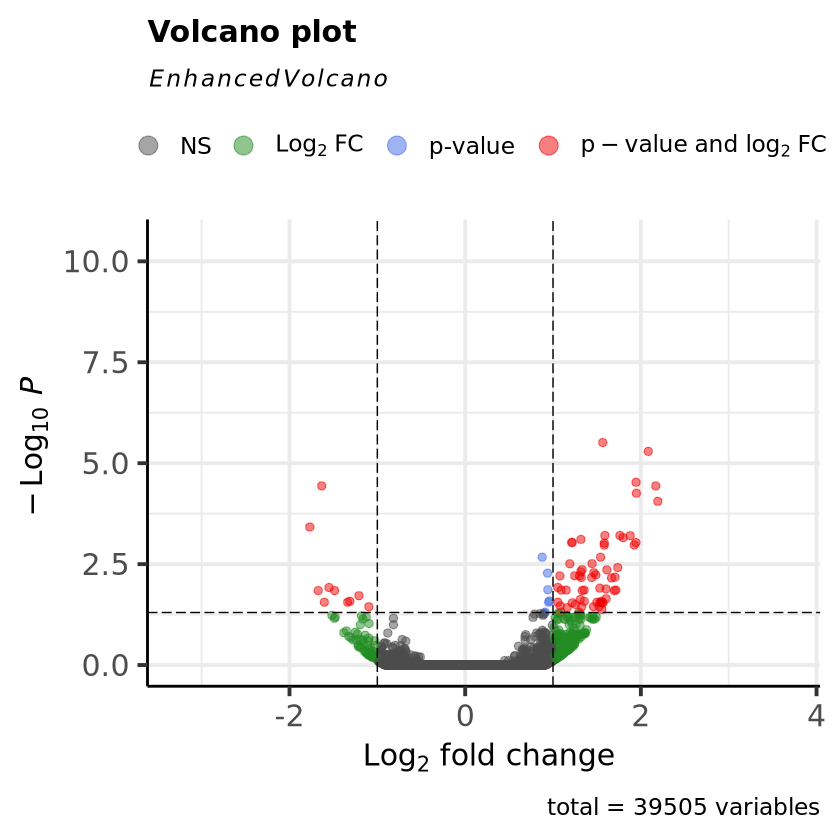

In [17]:
# hypoxic hypoxic vs. hypoxic control

contrast5 <- c("treatment", "hypoxic_hypoxic", "hypoxic_control")

# results of contrast1 with lfcThreshold=0.25 and normal shrinkage estimator
ls4<-lfcShrink(dds, # dds object
                      contrast = contrast5, # only coef or contrast can be specified
                      type="normal", lfcThreshold=0.25,
                      cooksCutoff=FALSE, independentFiltering=FALSE) # adding stuff to change outliers/padj=NA
summary(ls4)

EnhancedVolcano(ls4, 
                lab=NA,
                x = 'log2FoldChange',
                y='padj',
                pCutoff=0.05)

100 DMGs for hypoxic hypoxic

18 DMGs for hypoxic control

In [18]:
write.csv(as.data.frame(ls4), "/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_MethylRAD_analysis_2018/analysis/deseq_res_files/geneFeatures_res/HH_vs_HC.csv")

### hypoxic hypoxic vs. control hypoxic
HH vs. CH

using 'normal' for LFC shrinkage, the Normal prior from Love et al (2014).

Note that type='apeglm' and type='ashr' have shown to have less bias than type='normal'.
See ?lfcShrink for more details on shrinkage type, and the DESeq2 vignette.
Reference: https://doi.org/10.1093/bioinformatics/bty895




out of 24636 with nonzero total read count
adjusted p-value < 0.1
LFC > 0.25 (up)    : 0, 0%
LFC < -0.25 (down) : 0, 0%
outliers [1]       : 321, 1.3%
low counts [2]     : 0, 0%
(mean count < 0)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



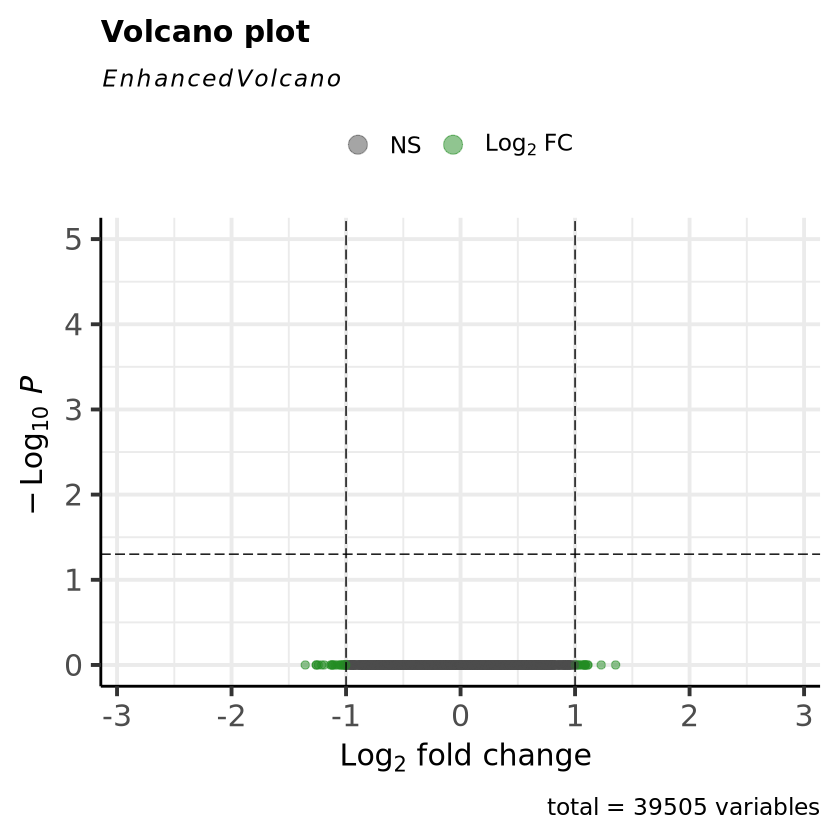

In [19]:
# hypoxic hypoxic vs. control hypoxic

contrast6 <- c("treatment", "hypoxic_hypoxic", "control_hypoxic")

# results of contrast1 with lfcThreshold=0.25 and normal shrinkage estimator
ls5<-lfcShrink(dds, # dds object
                      contrast = contrast6, # only coef or contrast can be specified
                      type="normal", lfcThreshold=0.25,
                      cooksCutoff=FALSE, independentFiltering=FALSE) # adding stuff to change outliers/padj=NA
summary(ls5)

EnhancedVolcano(ls5, 
                lab=NA,
                x = 'log2FoldChange',
                y='padj',
                pCutoff=0.05)

0 DMGs for hypoxic hypoxic

0 DMGs for control hypoxic

In [20]:
write.csv(as.data.frame(ls5), "/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_MethylRAD_analysis_2018/analysis/deseq_res_files/geneFeatures_res/HH_vs_CH.csv")

### hypoxic control vs. control hypoxic
HC vs. CH

using 'normal' for LFC shrinkage, the Normal prior from Love et al (2014).

Note that type='apeglm' and type='ashr' have shown to have less bias than type='normal'.
See ?lfcShrink for more details on shrinkage type, and the DESeq2 vignette.
Reference: https://doi.org/10.1093/bioinformatics/bty895




out of 24636 with nonzero total read count
adjusted p-value < 0.1
LFC > 0.25 (up)    : 88, 0.36%
LFC < -0.25 (down) : 183, 0.74%
outliers [1]       : 321, 1.3%
low counts [2]     : 12277, 50%
(mean count < 1)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



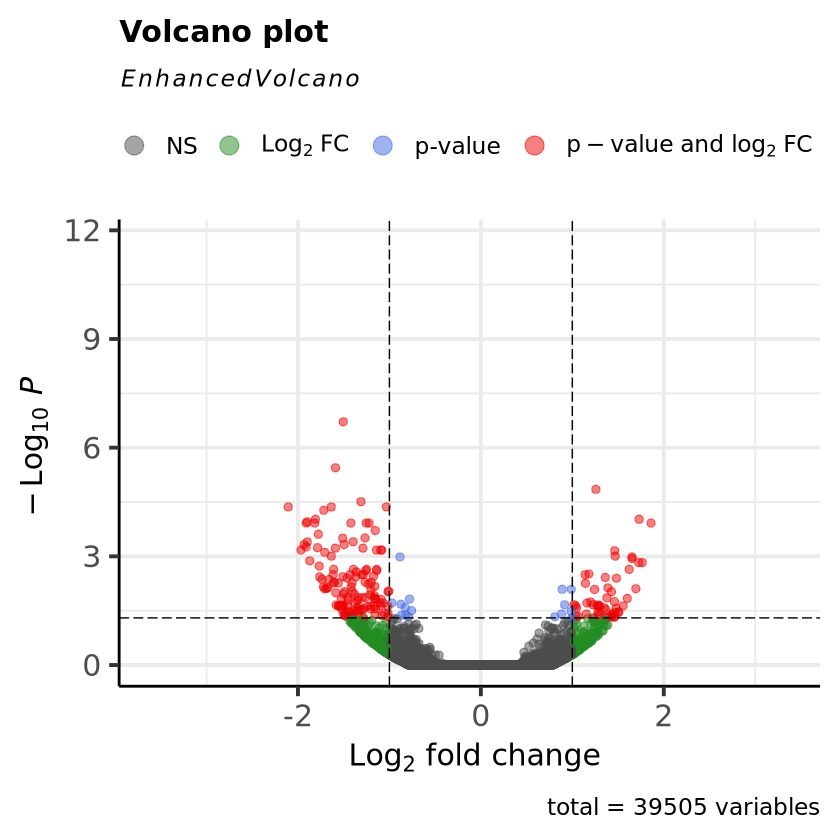

In [21]:
# hypoxic control vs. control hypoxic

contrast9 <- c("treatment", "hypoxic_control", "control_hypoxic")
# results of contrast1 with lfcThreshold=0.25 and normal shrinkage estimator
ls6<-lfcShrink(dds, # dds object
                      contrast = contrast9, # only coef or contrast can be specified
                      type="normal", lfcThreshold=0.25,
                      cooksCutoff=FALSE, independentFiltering=FALSE) # adding stuff to change outliers/padj=NA
summary(ls6)

EnhancedVolcano(ls6, 
                lab=NA,
                x = 'log2FoldChange',
                y='padj',
                pCutoff=0.05)

88 DMGs for hypoxic control

183 DMGs for control hypoxic

so there is a difference in methylation for *when* you experience hypoxic stress

In [22]:
write.csv(as.data.frame(ls6), "/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_MethylRAD_analysis_2018/analysis/deseq_res_files/geneFeatures_res/CH_vs_HC.csv")

### Phase 1 control vs. hypoxic
Cx vs. Hx

In [23]:
# creating DESeq2 objext from the matrix, with the design = treatment (which has both phase 1 and phase 2 variables)
p1_dds <- DESeqDataSetFromMatrix(countData = counts_filtered,
                                 colData = meta_filtered,
                                 design = ~Phase1)
p1_dds=DESeq(p1_dds)
resultsNames(p1_dds)

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”
estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing

-- replacing outliers and refitting for 659 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

estimating dispersions

fitting model and testing



[1] "Intercept"                 "Phase1_hypoxic_vs_control"

using 'normal' for LFC shrinkage, the Normal prior from Love et al (2014).

Note that type='apeglm' and type='ashr' have shown to have less bias than type='normal'.
See ?lfcShrink for more details on shrinkage type, and the DESeq2 vignette.
Reference: https://doi.org/10.1093/bioinformatics/bty895




out of 24613 with nonzero total read count
adjusted p-value < 0.1
LFC > 0.25 (up)    : 0, 0%
LFC < -0.25 (down) : 0, 0%
outliers [1]       : 636, 2.6%
low counts [2]     : 23, 0.093%
(mean count < 2)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



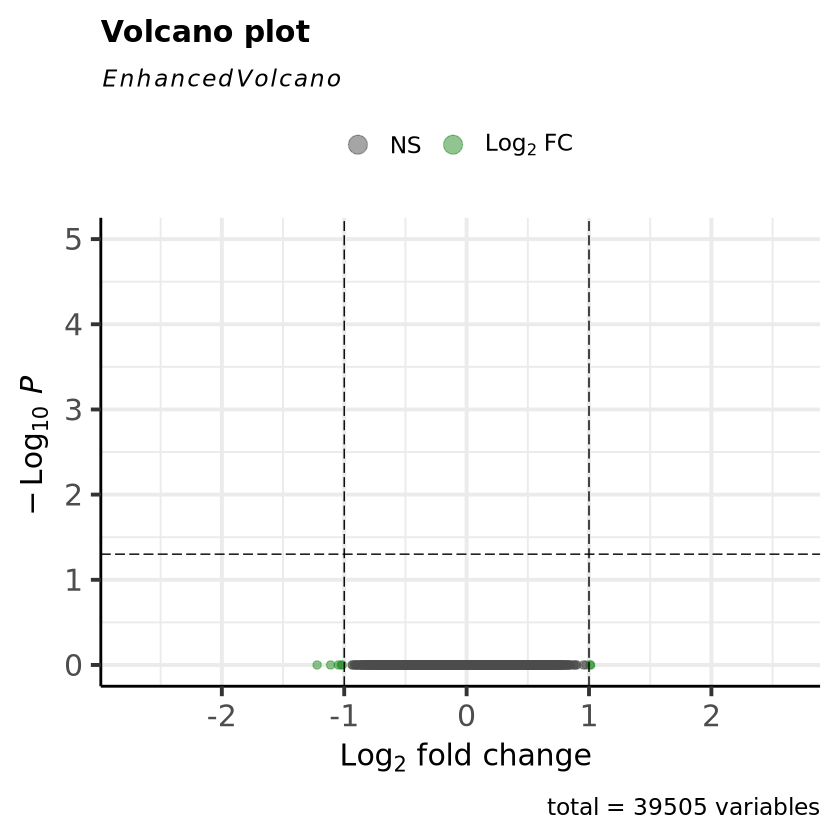

In [24]:
# phase 1 hypoxic vs. control

contrast7 <- c("Phase1", "hypoxic", "control")
# results of contrast1 with lfcThreshold=0.25 and normal shrinkage estimator
ls7<-lfcShrink(p1_dds, # dds object
                      contrast = contrast7, # only coef or contrast can be specified
                      type="normal", lfcThreshold=0.25,
                      cooksCutoff=FALSE, independentFiltering=FALSE) # adding stuff to change outliers/padj=NA
summary(ls7)

EnhancedVolcano(ls7, 
                lab=NA,
                x = 'log2FoldChange',
                y='padj',
                pCutoff=0.05)

0 DMGs for phase 1 hypoxic

0 DMGs for phase 1 control

In [25]:
write.csv(as.data.frame(ls7), "/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_MethylRAD_analysis_2018/analysis/deseq_res_files/geneFeatures_res/Hx_vs_Cx.csv")

### Phase 2 control vs. hypoxic
xC vs. xH

In [26]:
# creating DESeq2 objext from the matrix, with the design = treatment (which has both phase 1 and phase 2 variables)
p2_dds <- DESeqDataSetFromMatrix(countData = counts_filtered,
                              colData = meta_filtered, 
                              design = ~ Phase2)
p2_dds=DESeq(p2_dds)
resultsNames(p2_dds)

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”
estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing

-- replacing outliers and refitting for 617 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

estimating dispersions

fitting model and testing



[1] "Intercept"                 "Phase2_hypoxic_vs_control"

using 'normal' for LFC shrinkage, the Normal prior from Love et al (2014).

Note that type='apeglm' and type='ashr' have shown to have less bias than type='normal'.
See ?lfcShrink for more details on shrinkage type, and the DESeq2 vignette.
Reference: https://doi.org/10.1093/bioinformatics/bty895




out of 24612 with nonzero total read count
adjusted p-value < 0.1
LFC > 0.25 (up)    : 12, 0.049%
LFC < -0.25 (down) : 2, 0.0081%
outliers [1]       : 593, 2.4%
low counts [2]     : 11082, 45%
(mean count < 2)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



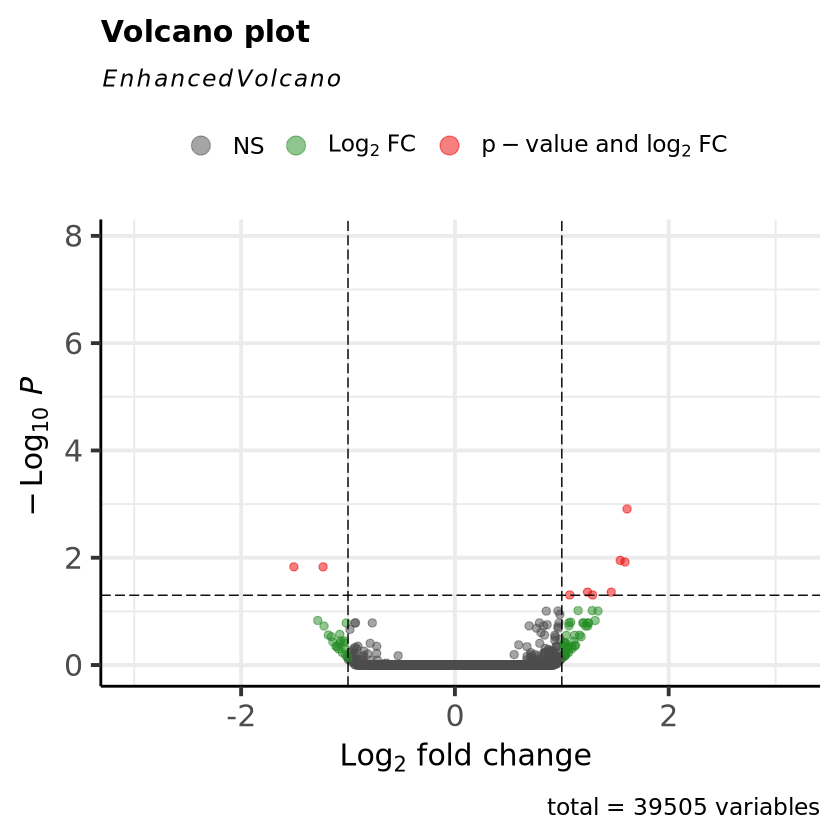

In [27]:
# phase 2 hypoxic vs. control

contrast8 <- c("Phase2", "hypoxic", "control")
# results of contrast1 with lfcThreshold=0.25 and normal shrinkage estimator
ls8<-lfcShrink(p2_dds, # dds object
                      contrast = contrast8, # only coef or contrast can be specified
                      type="normal", lfcThreshold=0.25,
                      cooksCutoff=FALSE, independentFiltering=FALSE) # adding stuff to change outliers/padj=NA
summary(ls8)

EnhancedVolcano(ls8, 
                lab=NA,
                x = 'log2FoldChange',
                y='padj',
                pCutoff=0.05)

12 DMGs for phase 2 hypoxic

2 DMGs for phase 2 control

In [28]:
write.csv(as.data.frame(ls8), "/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_MethylRAD_analysis_2018/analysis/deseq_res_files/geneFeatures_res/xH_vs_xC.csv")

## NMDS Plot
using DESeq2 dds object (which used the argument design=~treatment)

In [10]:
# MDS plot

# normalization & transformation
# vsd = variance stabilized expression matrix
vsd <- vst(dds)

# calculate sample distances
sample_dists <- assay(vsd) %>%
t() %>%
dist() %>%
as.matrix()

head(sample_dists)

# calculate MDS value from distance matrix
mdsData <- data.frame(cmdscale(sample_dists))
mds <- cbind(mdsData, as.data.frame(colData(vsd))) # combine with sample data
head(mds)

,BBB-WBO-B21,BBB-WBV-B70,BBO-BBO-B16,BBO-BBY-B27,BBO-WBO-B16,BBO-WBV-B64,BBR-BBB-B50,BBR-BBG-B38,BBR-BBY-B26,BBY-WBG-B42,WBB-WBV-W69,WBG-BBB-W56,WBG-WBG-W44,WBO-BBR-W03,WBO-WBV-W64,WBR-BBY-W25,WBV-WBO-W23,WBV-WBR-W12,WBY-BBV-W65,WBY-BBY-W30
BBB-WBO-B21,0.00000,25.26951,27.98667,28.33768,24.83890,24.61093,27.88445,26.26502,27.23278,25.93795,26.69531,29.99420,31.05860,34.53830,27.31821,30.47483,30.06066,33.56004,30.36751,29.61650
BBB-WBV-B70,25.26951,0.00000,25.49878,27.27005,25.06258,24.84487,25.15436,26.02244,25.96765,29.46282,26.45303,28.93185,30.82881,35.81382,26.51761,26.94332,29.32337,33.80563,29.80164,28.29598
BBO-BBO-B16,27.98667,25.49878,0.00000,25.28220,25.43588,27.67484,23.83551,24.03939,23.09087,29.77793,26.18716,25.32156,27.94313,36.37650,25.33292,26.64190,27.07970,30.69798,25.24050,24.87768
BBO-BBY-B27,28.33768,27.27005,25.28220,0.00000,27.33639,26.84488,25.59102,25.29641,22.65208,30.76244,26.98738,26.69386,29.10662,36.38398,26.67884,29.45109,28.85047,31.82239,25.78375,23.84393
BBO-WBO-B16,24.83890,25.06258,25.43588,27.33639,0.00000,25.12305,26.41277,26.40312,25.71643,28.31373,25.75825,28.57535,30.09903,35.60275,25.70888,29.29140,28.63880,31.76435,27.85379,28.04509
BBO-WBV-B64,24.61093,24.84487,27.67484,26.84488,25.12305,0.00000,27.57799,26.86506,25.31629,28.61948,24.28017,28.85819,29.76947,34.54480,26.64006,29.57758,30.03600,33.00908,29.69947,28.21922


,X1,X2,Phase1,Phase2,treatment,sizeFactor
,<dbl>,<dbl>,<chr>,<chr>,<fct>,<dbl>
BBB-WBO-B21,-7.135913,-10.887464,hypoxic,control,hypoxic_control,2.354451
BBB-WBV-B70,-2.629545,-7.979238,hypoxic,control,hypoxic_control,2.038074
BBO-BBO-B16,4.663573,1.179340,hypoxic,hypoxic,hypoxic_hypoxic,1.671849
BBO-BBY-B27,4.017543,2.409490,hypoxic,hypoxic,hypoxic_hypoxic,1.113611
BBO-WBO-B16,-2.351917,-6.954129,hypoxic,control,hypoxic_control,2.422014
BBO-WBV-B64,-5.438117,-6.949679,hypoxic,control,hypoxic_control,2.146717


In [13]:
mds$trmt <- ifelse(mds$treatment == 'hypoxic_control', 'HC',
                       ifelse(mds$treatment == 'control_hypoxic', 'CH',
                               ifelse(mds$treatment == 'hypoxic_hypoxic', 'HH', 'CC')))

mds

,X1,X2,Phase1,Phase2,treatment,sizeFactor,trmt
,<dbl>,<dbl>,<chr>,<chr>,<fct>,<dbl>,<chr>
BBB-WBO-B21,-7.1359128,-10.88746396,hypoxic,control,hypoxic_control,2.3544506,HC
BBB-WBV-B70,-2.6295446,-7.97923803,hypoxic,control,hypoxic_control,2.0380737,HC
BBO-BBO-B16,4.6635734,1.17933972,hypoxic,hypoxic,hypoxic_hypoxic,1.6718488,HH
BBO-BBY-B27,4.0175425,2.40948989,hypoxic,hypoxic,hypoxic_hypoxic,1.1136108,HH
BBO-WBO-B16,-2.3519168,-6.95412920,hypoxic,control,hypoxic_control,2.4220138,HC
BBO-WBV-B64,-5.4381172,-6.94967894,hypoxic,control,hypoxic_control,2.1467174,HC
BBR-BBB-B50,4.3855742,-0.01306858,hypoxic,hypoxic,hypoxic_hypoxic,0.9164791,HH
BBR-BBG-B38,2.6948988,-1.86197545,hypoxic,hypoxic,hypoxic_hypoxic,1.7367819,HH
BBR-BBY-B26,4.9119272,1.80551974,hypoxic,hypoxic,hypoxic_hypoxic,1.6504125,HH


In [19]:
write.csv(mds, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_MethylRAD_analysis_2018/analysis/deseq_res_files/nMDS_input_files/nmds_input.csv')

In [20]:
# if don't want to run above code...
mds <- read.csv('/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_MethylRAD_analysis_2018/analysis/deseq_res_files/nMDS_input_files/nmds_input.csv')

rownames(mds) <- mds$X

mds <- mds[,-1]

head(mds)

,X1,X2,Phase1,Phase2,treatment,sizeFactor,trmt
,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<chr>
BBB-WBO-B21,-7.135913,-10.887464,hypoxic,control,hypoxic_control,2.354451,HC
BBB-WBV-B70,-2.629545,-7.979238,hypoxic,control,hypoxic_control,2.038074,HC
BBO-BBO-B16,4.663573,1.179340,hypoxic,hypoxic,hypoxic_hypoxic,1.671849,HH
BBO-BBY-B27,4.017543,2.409490,hypoxic,hypoxic,hypoxic_hypoxic,1.113611,HH
BBO-WBO-B16,-2.351917,-6.954129,hypoxic,control,hypoxic_control,2.422014,HC
BBO-WBV-B64,-5.438117,-6.949679,hypoxic,control,hypoxic_control,2.146717,HC


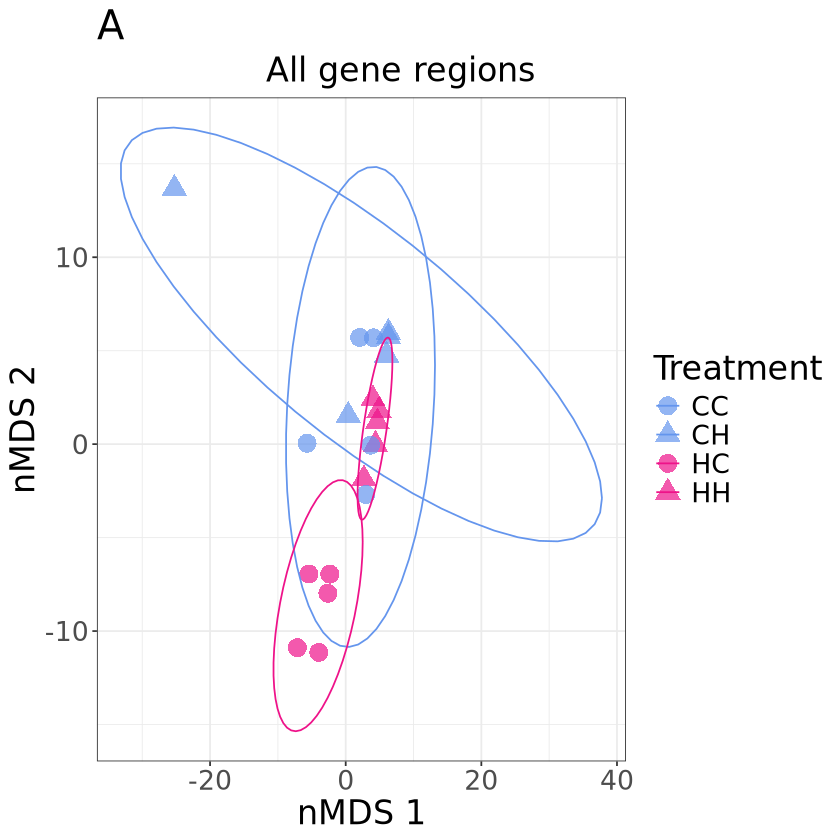

In [30]:
# plot
nmds_plot <- ggplot(mds, aes(X1, X2, col = trmt, shape = trmt)) + 
  geom_point(size = 5, alpha = 0.7) +
  scale_color_manual(
  name = "Treatment",
  values = c("CC" = "cornflowerblue",
             "CH" = "cornflowerblue",
             "HC" = "deeppink2",
             "HH" = "deeppink2"),
  labels = c("CC" = "CC", "CH" = "CH", "HC" = "HC", "HH" = "HH")
) +
scale_shape_manual(
  name = "Treatment",
  values = c("CC" = 16, "CH" = 17, "HC" = 16, "HH" = 17),
  labels = c("CC" = "CC", "CH" = "CH", "HC" = "HC", "HH" = "HH")
) + 
labs(x = "nMDS 1", 
     y = "nMDS 2", 
     title = 'A',
     subtitle = 'All gene regions') +
stat_ellipse() +
  guides(fill = guide_legend(override.aes = list(shape = c(21, 24, 21, 24),
                                                 fill = c("cornflowerblue", "cornflowerblue",
                                                          "deeppink2", "deeppink2")))) +
theme_bw() + 
theme(text = element_text(size = 20), plot.subtitle = element_text(hjust = .65),)
#guides(col = 'none', shape = 'none') 

nmds_plot

In [20]:
ggsave('/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_MethylRAD_analysis_2018/analysis/figures/nmds_TLlegend.pdf', nmds_plot)

Saving 6.67 x 6.67 in image


#### perMANOVA for all gene regions

In [21]:
# distance matrix
sample_dists <- dist(t(assay(vsd)))  # transpose so samples are rows
head(sample_dists)

# metadata
meta <- as.data.frame(colData(vsd))
head(meta)

[1] 25.26951 27.98667 28.33768 24.83890 24.61093 27.88445

,Phase1,Phase2,treatment,sizeFactor
,<chr>,<chr>,<fct>,<dbl>
BBB-WBO-B21,hypoxic,control,hypoxic_control,2.354451
BBB-WBV-B70,hypoxic,control,hypoxic_control,2.038074
BBO-BBO-B16,hypoxic,hypoxic,hypoxic_hypoxic,1.671849
BBO-BBY-B27,hypoxic,hypoxic,hypoxic_hypoxic,1.113611
BBO-WBO-B16,hypoxic,control,hypoxic_control,2.422014
BBO-WBV-B64,hypoxic,control,hypoxic_control,2.146717


In [22]:
adonis2(sample_dists ~ Phase1 * Phase2, data = meta, permutations = 999)

,Df,SumOfSqs,R2,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Phase1,1,539.6145,0.06804895,1.364367,0.016
Phase2,1,599.7671,0.07563459,1.516458,0.005
Phase1:Phase2,1,462.3333,0.05830327,1.168969,0.076
Residual,16,6328.0843,0.79801318,NA,NA
Total,19,7929.7991,1.00000000,NA,NA


- **Phase 1**: explains 6.8% of variance (R2) and stat. significant (P = 0.017)
- **Phase 2**: explains 7.5% of variance (R2) and stat. significant (P = 0.004)
- **Phase1:Phase2**: explains 5.8% of variance (R2) and almost signif but not (P = 0.088) - there's some combined effect of phase 1 and 2, but doesn't strongly modify sample structure beyond their individual main effects
- **Residual**: explains 79.8% of variance (unexplained variance, noise, individual differences, other variables)

Phase 1 and 2 treatments significantly affect overall community structure

interaction of phase 1 and 2 showed weaker, non-signif trend - so effects of phase 1 and 2 are largely additive (not interactive)

### nMDS for sig DMG
doing the same NMDS plot but only for genes that were identified as **sig. DM in any pairwise comparison**

In [23]:
# CC vs. HC
CC_HC <- read.csv('/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_MethylRAD_analysis_2018/analysis/deseq_res_files/pairwise_results/CC_vs_HC.csv')
df1 <- filter(CC_HC, padj < 0.05)
rownames(df1) <- df1$X

# CH_HC
CH_HC <- read.csv('/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_MethylRAD_analysis_2018/analysis/deseq_res_files/pairwise_results/CH_vs_HC.csv')
df2 <- filter(CH_HC, padj < 0.05)
rownames(df2) <- df2$X

# HH_HC
HH_HC <- read.csv('/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_MethylRAD_analysis_2018/analysis/deseq_res_files/pairwise_results/HH_vs_HC.csv')
df3 <- filter(HH_HC, padj < 0.05)
rownames(df3) <- df3$X

# HH_CH
HH_CH <- read.csv('/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_MethylRAD_analysis_2018/analysis/deseq_res_files/pairwise_results/HH_vs_CH.csv')
df4 <- filter(HH_CH, padj < 0.05)
rownames(df4) <- df4$X

# HH_CC
HH_CC <- read.csv('/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_MethylRAD_analysis_2018/analysis/deseq_res_files/pairwise_results/CC_vs_HH.csv')
df5 <- filter(HH_CC, padj < 0.05)
rownames(df5) <- df5$X

# CC_CH
CC_CH <- read.csv('/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_MethylRAD_analysis_2018/analysis/deseq_res_files/pairwise_results/CC_vs_CH.csv')
df6 <- filter(CC_CH, padj < 0.05)
rownames(df6) <- df6$X

# Define the list of dataframes containing DMGs
dmg_dfs <- list(df1, df2, df3, df4, df5, df6)

# Extract unique gene names from all dataframes
all_dmg_genes <- unique(unlist(lapply(dmg_dfs, function(x) rownames(x))))

In [24]:
# MDS plot

# normalization & transformation
vsd <- vst(dds)

vsd_sig <- vsd[all_dmg_genes, ]

# calculate sample distances
sample_dists <- assay(vsd_sig) %>%
t() %>%
dist() %>%
as.matrix()

# calculate MDS value from distance matrix
mdsData <- data.frame(cmdscale(sample_dists))
mds_sig <- cbind(mdsData, as.data.frame(colData(vsd_sig))) # combine with sample data
head(mds_sig)

,X1,X2,Phase1,Phase2,treatment,sizeFactor
,<dbl>,<dbl>,<chr>,<chr>,<fct>,<dbl>
BBB-WBO-B21,-3.827181,-0.5541501,hypoxic,control,hypoxic_control,2.354451
BBB-WBV-B70,-3.085163,-0.3468558,hypoxic,control,hypoxic_control,2.038074
BBO-BBO-B16,1.238775,-0.9894135,hypoxic,hypoxic,hypoxic_hypoxic,1.671849
BBO-BBY-B27,1.280828,-1.0226017,hypoxic,hypoxic,hypoxic_hypoxic,1.113611
BBO-WBO-B16,-3.128118,-0.4936210,hypoxic,control,hypoxic_control,2.422014
BBO-WBV-B64,-3.243235,-0.2936882,hypoxic,control,hypoxic_control,2.146717


In [40]:
write.csv(mds, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_MethylRAD_analysis_2018/analysis/deseq_res_files/geneFeatures_res/nmds_input_sigOnly.csv')

In [28]:
mds_sig <- read.csv('/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_MethylRAD_analysis_2018/analysis/deseq_res_files/nMDS_input_files/nmds_input_sigOnly.csv')

In [26]:
mds_sig$trmt <- ifelse(mds$treatment == 'hypoxic_control', 'HC',
                       ifelse(mds$treatment == 'control_hypoxic', 'CH',
                               ifelse(mds$treatment == 'hypoxic_hypoxic', 'HH', 'CC')))

mds_sig

,X1,X2,Phase1,Phase2,treatment,sizeFactor,trmt
,<dbl>,<dbl>,<chr>,<chr>,<fct>,<dbl>,<chr>
BBB-WBO-B21,-3.82718142,-0.5541501,hypoxic,control,hypoxic_control,2.3544506,HC
BBB-WBV-B70,-3.08516281,-0.3468558,hypoxic,control,hypoxic_control,2.0380737,HC
BBO-BBO-B16,1.23877522,-0.9894135,hypoxic,hypoxic,hypoxic_hypoxic,1.6718488,HH
BBO-BBY-B27,1.28082831,-1.0226017,hypoxic,hypoxic,hypoxic_hypoxic,1.1136108,HH
BBO-WBO-B16,-3.12811759,-0.4936210,hypoxic,control,hypoxic_control,2.4220138,HC
BBO-WBV-B64,-3.24323507,-0.2936882,hypoxic,control,hypoxic_control,2.1467174,HC
BBR-BBB-B50,1.19343350,-0.5500774,hypoxic,hypoxic,hypoxic_hypoxic,0.9164791,HH
BBR-BBG-B38,0.56651723,-1.3298165,hypoxic,hypoxic,hypoxic_hypoxic,1.7367819,HH
BBR-BBY-B26,1.26860810,-0.8672517,hypoxic,hypoxic,hypoxic_hypoxic,1.6504125,HH


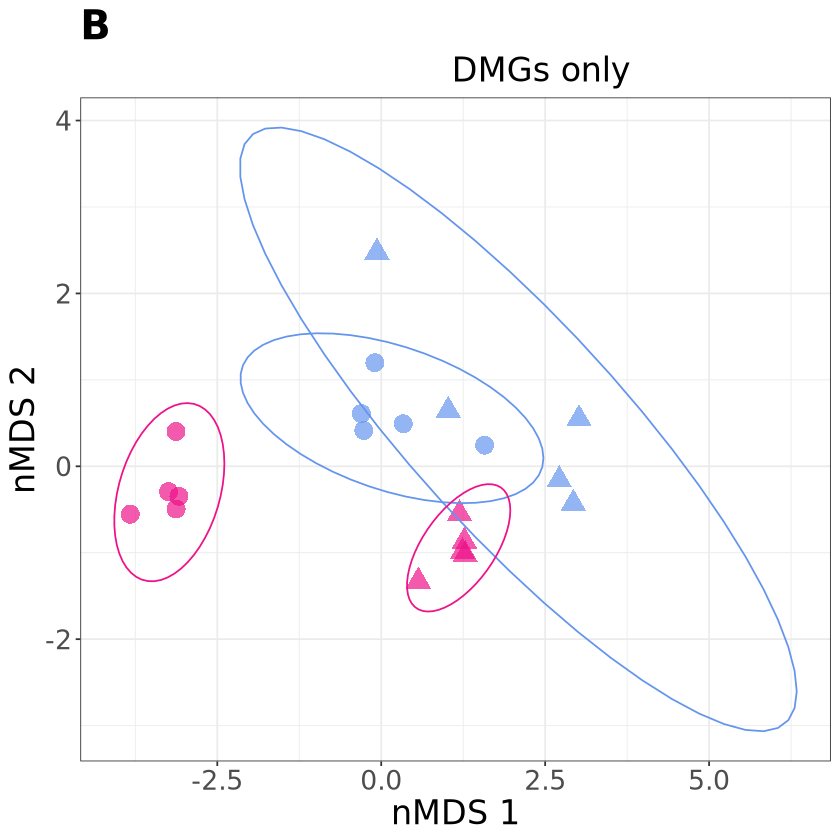

In [36]:
# plot
nmds_plot_sigOnly <- ggplot(mds_sig, aes(X1, X2, col = trmt, shape = trmt)) + 
  geom_point(size = 5, alpha = 0.7) +
  scale_color_manual(
  name = "Treatment",
  values = c("CC" = "cornflowerblue",
             "CH" = "cornflowerblue",
             "HC" = "deeppink2",
             "HH" = "deeppink2"),
  labels = c("CC" = "CC", "CH" = "CH", "HC" = "HC", "HH" = "HH")
) +
scale_shape_manual(
  name = "Treatment",
  values = c("CC" = 16, "CH" = 17, "HC" = 16, "HH" = 17),
  labels = c("CC" = "CC", "CH" = "CH", "HC" = "HC", "HH" = "HH")
) + 
labs(x = "nMDS 1", 
     y = "nMDS 2", 
     title = 'B',
     subtitle = 'DMGs only') +
stat_ellipse() +
  guides(fill = guide_legend(override.aes = list(shape = c(21, 24, 21, 24),
                                                 fill = c("cornflowerblue", "cornflowerblue",
                                                          "deeppink2", "deeppink2")))) +
theme_bw() +
 theme(text = element_text(size = 20),
      plot.subtitle = element_text(hjust = .65),
      plot.title = element_text(face = "bold")) +
guides(col = 'none', shape = 'none') 

nmds_plot_sigOnly


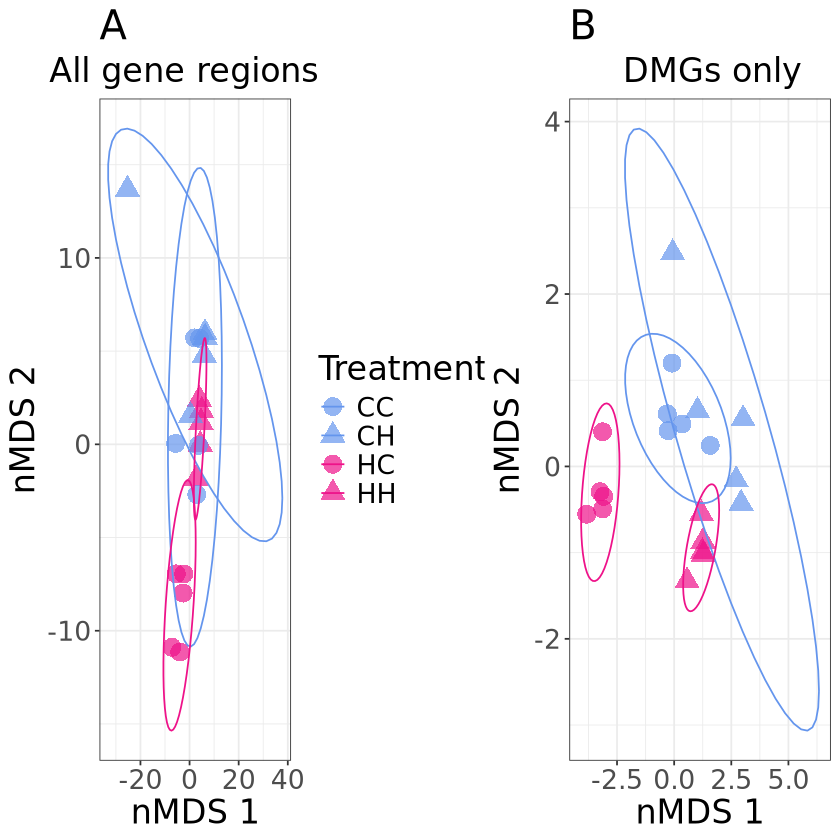

In [34]:
fig2 <- plot_grid(nmds_plot, nmds_plot_sigOnly, ncol = 2, rel_widths = c(1.5, 1.1))
fig2

In [35]:
ggsave('/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_MethylRAD_analysis_2018/analysis/figures/fig2.pdf', fig2, width = 10, height = 5)

when considering only genes that are significantly differentially methylated in any pairwise comparison, methylation status explains 61.61% of the variation

#### perMANOVA for only sig. DMGs

In [32]:
# distance matrix
sample_dists_sig <- dist(t(assay(vsd_sig)))  # transpose so samples are rows
head(sample_dists)

# metadata
meta_sig <- as.data.frame(colData(vsd_sig))
head(meta_sig)

,BBB-WBO-B21,BBB-WBV-B70,BBO-BBO-B16,BBO-BBY-B27,BBO-WBO-B16,BBO-WBV-B64,BBR-BBB-B50,BBR-BBG-B38,BBR-BBY-B26,BBY-WBG-B42,WBB-WBV-W69,WBG-BBB-W56,WBG-WBG-W44,WBO-BBR-W03,WBO-WBV-W64,WBR-BBY-W25,WBV-WBO-W23,WBV-WBR-W12,WBY-BBV-W65,WBY-BBY-W30
BBB-WBO-B21,0.000000,1.919923,5.410246,5.466946,1.763607,1.790060,5.385106,4.875742,5.348206,2.614969,4.204486,7.021459,5.916808,5.367693,4.353793,5.459876,4.878878,5.082970,7.149048,6.764092
BBB-WBV-B70,1.919923,0.000000,4.774980,4.837364,1.744168,1.711340,4.723106,4.281746,4.701681,2.697757,3.541746,6.347174,5.280823,4.773054,3.745514,4.811491,4.335260,4.473898,6.473477,6.064752
BBO-BBO-B16,5.410246,4.774980,0.000000,2.157613,4.734682,4.954182,2.031221,2.107052,1.934837,5.200248,3.072486,3.084147,2.928041,4.383477,3.178248,2.912592,2.999941,3.948126,3.145556,2.924180
BBO-BBY-B27,5.466946,4.837364,2.157613,0.000000,4.911270,4.967494,2.358872,2.196832,1.848173,5.273661,3.173118,2.981176,2.992013,4.337995,3.253657,3.238625,3.116614,3.973854,3.418214,2.753341
BBO-WBO-B16,1.763607,1.744168,4.734682,4.911270,0.000000,1.862497,4.817342,4.318636,4.802638,2.832744,3.635979,6.399900,5.323054,4.929055,3.885978,4.860662,4.349908,4.545534,6.504815,6.147967
BBO-WBV-B64,1.790060,1.711340,4.954182,4.967494,1.862497,0.000000,4.872629,4.440837,4.881423,2.659643,3.561377,6.538976,5.345858,4.904400,3.782165,4.984416,4.308110,4.643991,6.572725,6.206379


,Phase1,Phase2,treatment,sizeFactor
,<chr>,<chr>,<fct>,<dbl>
BBB-WBO-B21,hypoxic,control,hypoxic_control,2.354451
BBB-WBV-B70,hypoxic,control,hypoxic_control,2.038074
BBO-BBO-B16,hypoxic,hypoxic,hypoxic_hypoxic,1.671849
BBO-BBY-B27,hypoxic,hypoxic,hypoxic_hypoxic,1.113611
BBO-WBO-B16,hypoxic,control,hypoxic_control,2.422014
BBO-WBV-B64,hypoxic,control,hypoxic_control,2.146717


In [33]:
adonis2(sample_dists_sig ~ Phase1 * Phase2, data = meta_sig, permutations = 999)

,Df,SumOfSqs,R2,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Phase1,1,32.21411,0.19955786,8.028072,0.001
Phase2,1,50.14185,0.31061543,12.495840,0.001
Phase1:Phase2,1,14.86853,0.09210659,3.705383,0.025
Residual,16,64.20294,0.39772012,NA,NA
Total,19,161.42744,1.00000000,NA,NA


- **Phase 1**: explains 19.9% of variance (R2) and stat. significant (P = 0.001)
- **Phase 2**: explains 31.1% of variance (R2) and stat. significant (P = 0.001)
- **Phase1:Phase2**: explains 9.2% of variance (R2) and stat. significant (P = 0.025)
- **Residual**: explains 39.7% of variance (unexplained variance, noise, individual differences, other variables)

Phase 1 and 2 treatments significantly affect overall community structure

interaction of phase 1 and 2 is significant - the effect of phase 1 depends on phase 2 (combined effect isn't additive)

## Heatmap

In [43]:
vsd <- vst(dds)

In [44]:
library(pheatmap)

In [45]:
ntd <- normTransform(dds)

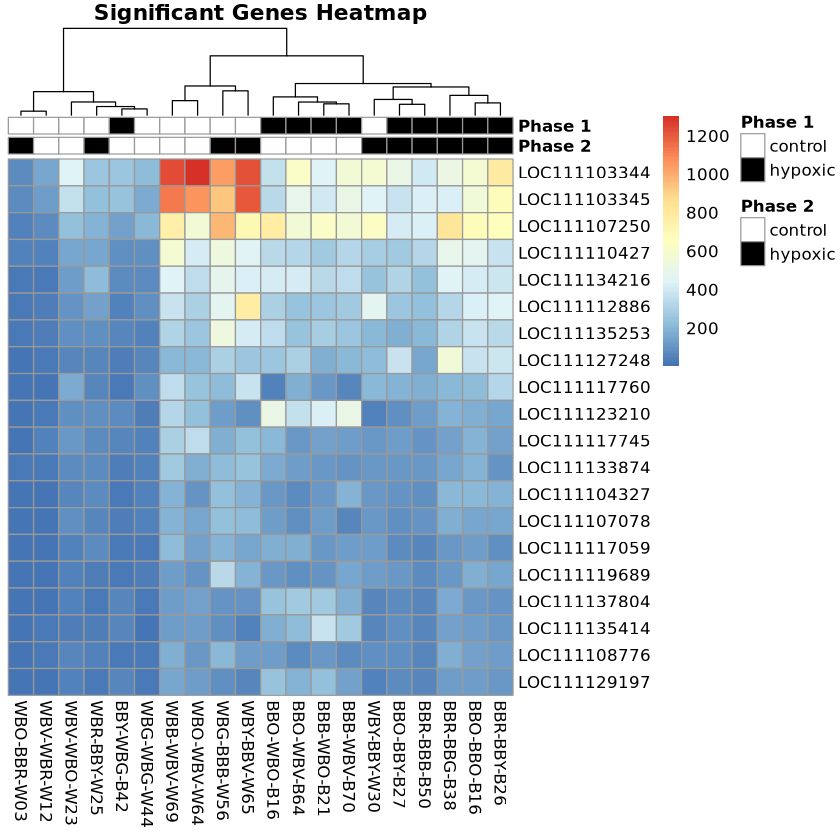

In [46]:
# Define the list of dataframes containing DMGs
dmg_dfs <- list(df1, df2, df3, df4, df5, df6)

# Extract unique gene names from all dataframes
all_dmg_genes <- unique(unlist(lapply(dmg_dfs, function(x) rownames(x))))

# Filter counts for significant genes
sig_counts <- counts(dds, normalized=TRUE)[all_dmg_genes, ]

# Select top 20 significant genes by row mean
select_sig <- order(rowMeans(sig_counts), decreasing=TRUE)[1:20]

# Create annotation data frame
df <- as.data.frame(colData(dds)[,c("Phase2", "Phase1")])
colnames(df) <- c("Phase 2", "Phase 1")

# Define color palette
phase1_colors <- c("control" = "white", "hypoxic" = "black")
phase2_colors <- c("control" = "white", "hypoxic" = "black")

# Create heatmap
pheatmap(assay(dds)[all_dmg_genes[select_sig], ], 
         cluster_rows=FALSE, show_rownames=TRUE,
         cluster_cols=TRUE, 
         annotation_col=df,
         annotation_colors= list('Phase 1'=phase1_colors, 'Phase 2'=phase2_colors),
         main="Significant Genes Heatmap")

^ selected top 20 genes by row mean

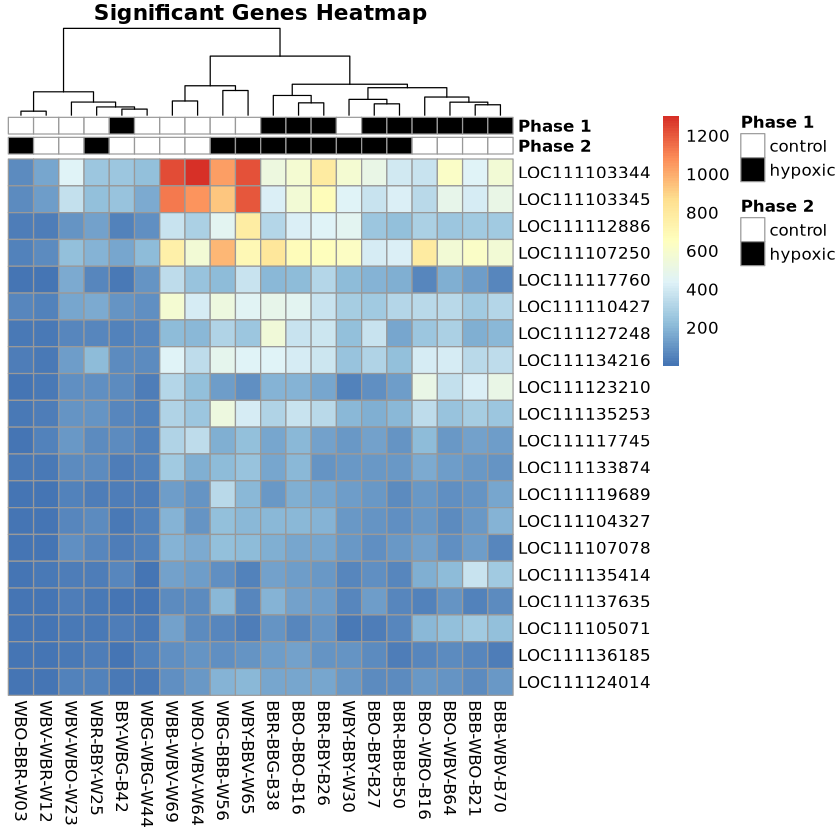

In [47]:
# Define the list of dataframes containing DMGs
dmg_dfs <- list(df1, df2, df3, df4, df5, df6)

# Extract unique gene names from all dataframes
all_dmg_genes <- unique(unlist(lapply(dmg_dfs, function(x) rownames(x))))

# Filter counts for significant genes
sig_counts <- counts(dds, normalized=TRUE)[all_dmg_genes, ]

# Calculate row-wise standard deviation
std_dev <- apply(sig_counts, 1, sd)

# Select top 20 genes by standard deviation
select_sig <- order(std_dev, decreasing=TRUE)[1:20]

# Create annotation data frame
df <- as.data.frame(colData(dds)[,c("Phase2", "Phase1")])
colnames(df) <- c("Phase 2", "Phase 1")

# Define color palette
phase1_colors <- c("control" = "white", "hypoxic" = "black")
phase2_colors <- c("control" = "white", "hypoxic" = "black")

# Create heatmap
pheatmap(assay(dds)[all_dmg_genes[select_sig], ], 
         cluster_rows=FALSE, show_rownames=TRUE,
         cluster_cols=TRUE, 
         annotation_col=df,
         annotation_colors= list('Phase 1'=phase1_colors, 'Phase 2'=phase2_colors),
         main="Significant Genes Heatmap")

^ selected top 20 genes with highest row-wise standard deviation

## Overlap of sig DMGs with previous method

in the previous method, I was only counting methylation in exons for meta-features (genes) - since realizing, I now have methylation happening anywhere in the gene region included. My results are still similar and showing the same general pattern, but would now like to see how much has remained the same for sig. DMGs

In [48]:
# pulling out sig DMGs for pairwise comparisons against HC (hypoxic control)

# OG = original DMGs
OG_sig_HH <- read.csv('/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_MethylRAD_analysis_2018/analysis/deseq_res_files/sig_DMGs_gene_names/sig_HH_HC_genes.csv')
OG_sig_CH <- read.csv('/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_MethylRAD_analysis_2018/analysis/deseq_res_files/sig_DMGs_gene_names/sig_CH_HC_genes.csv')
OG_sig_CC <- read.csv('/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_MethylRAD_analysis_2018/analysis/deseq_res_files/sig_DMGs_gene_names/sig_CC_HC_genes.csv')

# new DMGs
new_sig_HH <- read.csv('/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_MethylRAD_analysis_2018/analysis/deseq_res_files/geneFeatures_res/sig_DMGs/sig_HH_HC_genes.csv')
new_sig_CH <- read.csv('/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_MethylRAD_analysis_2018/analysis/deseq_res_files/geneFeatures_res/sig_DMGs/sig_CH_HC_genes.csv')
new_sig_CC <- read.csv('/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_MethylRAD_analysis_2018/analysis/deseq_res_files/geneFeatures_res/sig_DMGs/sig_CC_HC_genes.csv')

In [49]:
# combining OG dmgs into one dataframe

OG_sig_HH$pair <- 'HH_HC'
OG_sig_CH$pair <- 'CH_HC'
OG_sig_CC$pair <- 'CC_HC'

OG_dmg <- rbind(OG_sig_HH, OG_sig_CH, OG_sig_CC)
head(OG_dmg)

,X,symbol,baseMean,log2FC,lfcSE,stat,pvalue,padj,name,pair
,<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
1,1,LOC111099548,42.89749,1.071897,0.1866766,4.402785,1.068701e-05,2.130990e-03,kinesin-like protein KIF17,HH_HC
2,2,LOC111099571,29.77511,1.868561,0.2605608,6.211837,5.236873e-10,9.398093e-07,histone RNA hairpin-binding protein-like,HH_HC
3,3,LOC111099928,11.39894,1.304678,0.2959526,3.563674,3.657007e-04,3.095691e-02,uncharacterized LOC111099928,HH_HC
4,4,LOC111100608,22.80004,1.616395,0.2667483,5.122415,3.016477e-07,1.353342e-04,DDRGK domain-containing protein 1-like,HH_HC
5,5,LOC111100898,38.23971,1.069928,0.2282000,3.593025,3.268615e-04,2.820124e-02,"uncharacterized LOC111100898, transcript variant X3",HH_HC
6,6,LOC111101122,25.83962,-1.173186,0.2628607,-3.512075,4.446230e-04,3.626911e-02,lysophospholipid acyltransferase 7-like,HH_HC


In [50]:
# combining new dmgs into one dataframe
new_sig_HH$pair <- 'HH_HC'
new_sig_CH$pair <- 'CH_HC'
new_sig_CC$pair <- 'CC_HC'

new_dmg <- rbind(new_sig_HH, new_sig_CH, new_sig_CC)
head(new_dmg)

,X,symbol,baseMean,log2FC,lfcSE,stat,pvalue,padj,name,pair
,<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
1,1,LOC111099548,42.98619,1.054197,0.1952758,4.118262,3.817409e-05,0.0119860976,kinesin-like protein KIF17,HH_HC
2,2,LOC111099571,31.11937,1.583044,0.2784773,4.786904,1.693737e-06,0.0010731159,histone RNA hairpin-binding protein-like,HH_HC
3,3,LOC111099930,35.09830,1.318024,0.2167696,4.927003,8.350045e-07,0.0007732142,"uncharacterized LOC111099930, transcript variant X1",HH_HC
4,4,LOC111100608,22.90296,1.584298,0.2760621,4.833325,1.342715e-06,0.0009508000,DDRGK domain-containing protein 1-like,HH_HC
5,5,LOC111101237,37.09165,1.078964,0.1927178,4.301443,1.696897e-05,0.0061900739,putative 2'-deoxynucleoside 5'-phosphate N-hydrolase 1,HH_HC
6,6,LOC111101984,10.15872,1.604290,0.3316931,4.082963,4.446518e-05,0.0130554113,von Willebrand factor D and EGF domain-containing protein-like,HH_HC


looking at overlap of new and OG dmgs **overall**

In [51]:
library(ggvenn)

Loading required package: grid



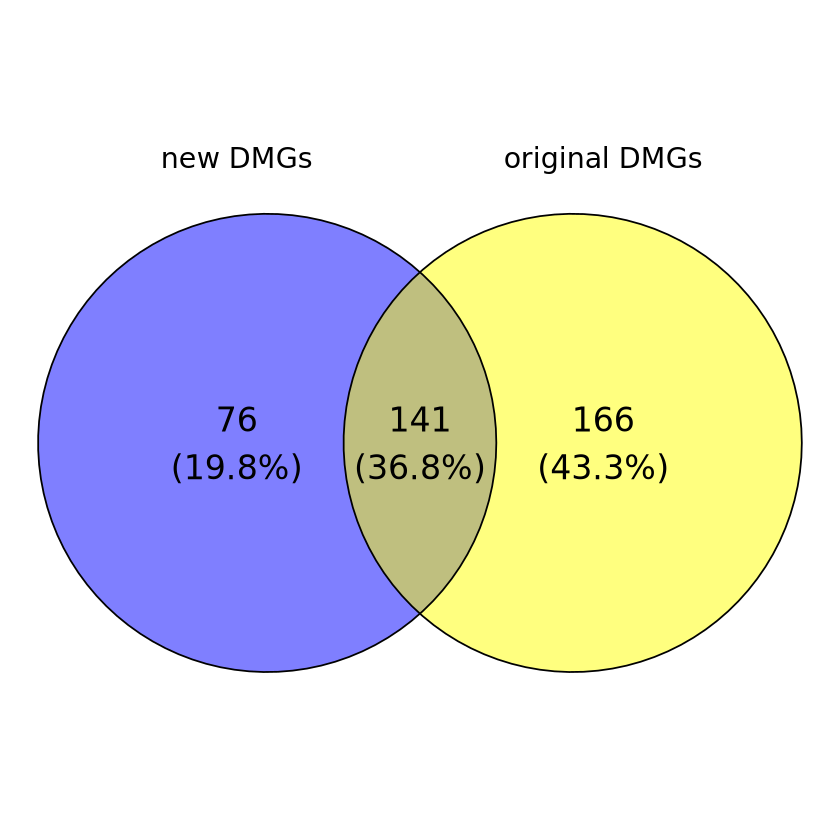

In [52]:
x = list(A = new_dmg$symbol,
         B = OG_dmg$symbol)

names(x) <- c('new DMGs',
             'original DMGs')

# same colors as used in the volcano plots
#custom_colors <- c('#F8766D',  '#7CAE00', )

#png(filename="/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_MethylRAD_analysis_2018/analysis/deseq_res_files/venn_genes/venn_diagram.png")


ggvenn(x,
      set_name_size = 6,
       text_size = 7,
      stroke_size = 0.5, 
       show_percentage = TRUE)


in total, 141 sig DMGs that were originally identified are still significantly DMG in the new analysis, with an additional 76 genes that were not previously identified


looking by pairwise comparison


### hypoxic hypoxic vs. hypoxic control

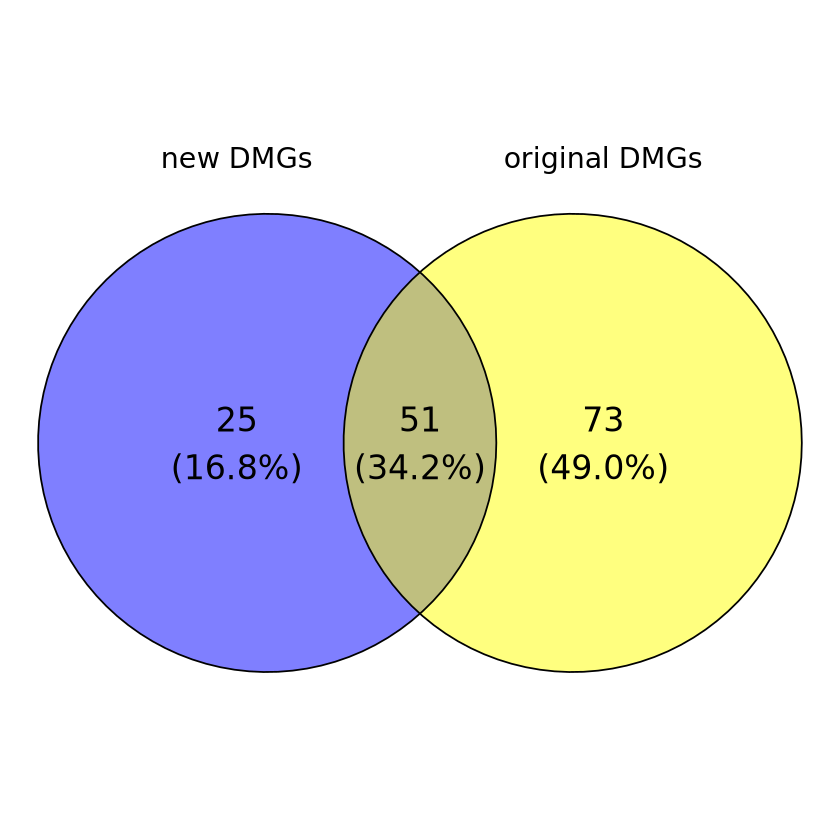

In [53]:
x = list(A = new_sig_HH$symbol,
         B = OG_sig_HH$symbol)

names(x) <- c('new DMGs',
              'original DMGs')


ggvenn(x,
      set_name_size = 6,
       text_size = 7,
      stroke_size = 0.5, 
       show_percentage = TRUE)

51 sig. DMGs remain the same in this comparison, but 25 new sig DMGs have been identified with the new analysis 

### control hypoxic vs. hypoxic control

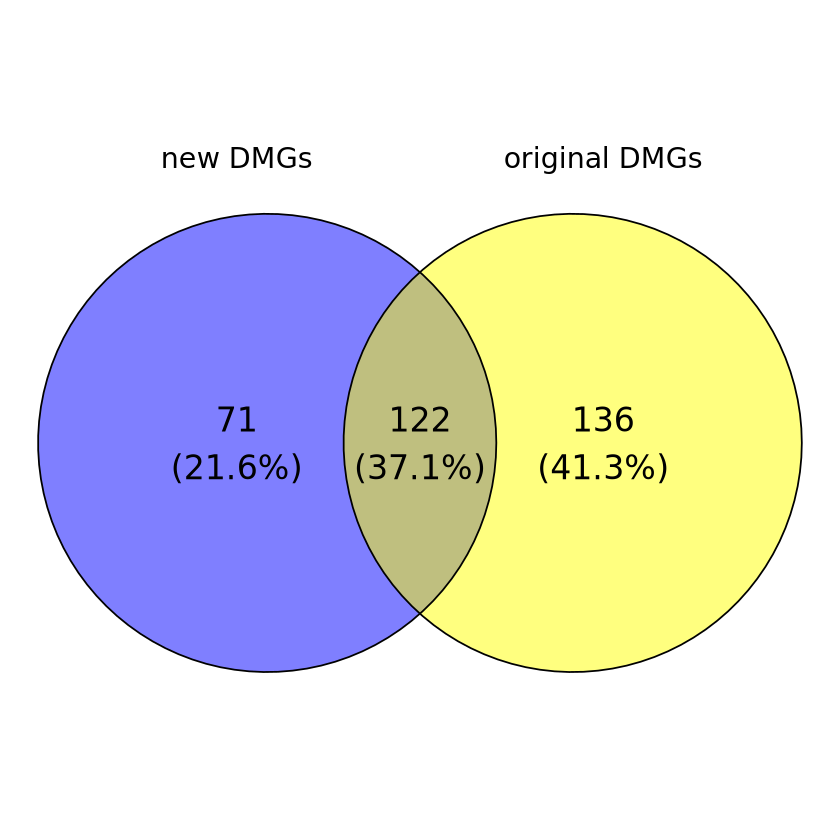

In [54]:
x = list(A = new_sig_CH$symbol,
         B = OG_sig_CH$symbol)

names(x) <- c('new DMGs',
              'original DMGs')


ggvenn(x,
      set_name_size = 6,
       text_size = 7,
      stroke_size = 0.5, 
       show_percentage = TRUE)

122 significantly differentially methylated genes remained the same for both analyses, but there are 71 that weren't originally identified in the OG analysis

### control control vs. hypoxic control

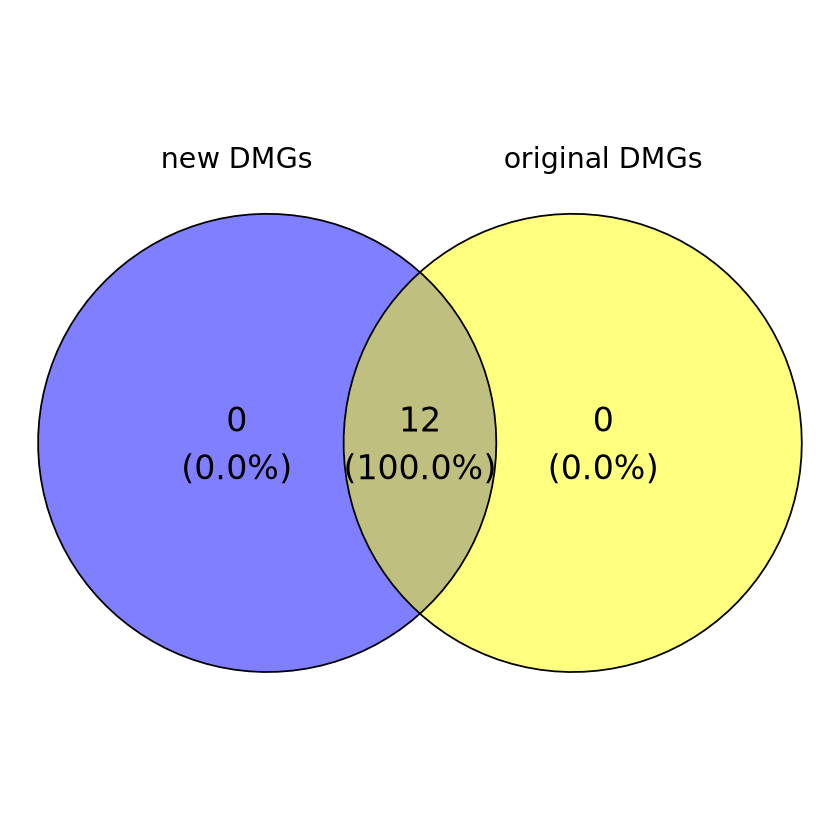

In [55]:
x = list(A = new_sig_CC$symbol,
         B = OG_sig_CC$symbol)

names(x) <- c('new DMGs',
              'original DMGs')


ggvenn(x,
      set_name_size = 6,
       text_size = 7,
      stroke_size = 0.5, 
       show_percentage = TRUE)

so nothing changed for the differentially methylated genes found in the pairwise comparison of control control vs. hypoxic control

In [56]:
write.csv(new_dmg, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_MethylRAD_analysis_2018/analysis/deseq_res_files/geneFeatures_res/sig_DMGs/all_sig_DMGs.csv')

In [57]:
head(new_sig_HH)
head(new_sig_CH)
head(new_sig_CC)

,X,symbol,baseMean,log2FC,lfcSE,stat,pvalue,padj,name,pair
,<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
1,1,LOC111099548,42.98619,1.054197,0.1952758,4.118262,3.817409e-05,0.0119860976,kinesin-like protein KIF17,HH_HC
2,2,LOC111099571,31.11937,1.583044,0.2784773,4.786904,1.693737e-06,0.0010731159,histone RNA hairpin-binding protein-like,HH_HC
3,3,LOC111099930,35.09830,1.318024,0.2167696,4.927003,8.350045e-07,0.0007732142,"uncharacterized LOC111099930, transcript variant X1",HH_HC
4,4,LOC111100608,22.90296,1.584298,0.2760621,4.833325,1.342715e-06,0.0009508000,DDRGK domain-containing protein 1-like,HH_HC
5,5,LOC111101237,37.09165,1.078964,0.1927178,4.301443,1.696897e-05,0.0061900739,putative 2'-deoxynucleoside 5'-phosphate N-hydrolase 1,HH_HC
6,6,LOC111101984,10.15872,1.604290,0.3316931,4.082963,4.446518e-05,0.0130554113,von Willebrand factor D and EGF domain-containing protein-like,HH_HC


,X,symbol,baseMean,log2FC,lfcSE,stat,pvalue,padj,name,pair
,<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
1,1,LOC111099548,42.98619,-1.2672684,0.2026166,-5.020656,5.149523e-07,0.0003099498,kinesin-like protein KIF17,CH_HC
2,2,LOC111099571,31.11937,-1.4181929,0.2861630,-4.082264,4.459915e-05,0.0069725275,histone RNA hairpin-binding protein-like,CH_HC
3,3,LOC111099585,36.32548,0.9854391,0.2091056,3.517070,4.363394e-04,0.0332446433,lys-63-specific deubiquitinase BRCC36-like,CH_HC
4,4,LOC111099930,35.09830,-1.1981548,0.2270953,-4.175140,2.978035e-05,0.0051868387,"uncharacterized LOC111099930, transcript variant X1",CH_HC
5,5,LOC111099978,37.23914,1.1530905,0.2612132,3.457293,5.456316e-04,0.0390971051,"oncoprotein-induced transcript 3 protein-like, transcript variant X1",CH_HC
6,6,LOC111100608,22.90296,-1.4622657,0.2851646,-4.251109,2.127149e-05,0.0040010349,DDRGK domain-containing protein 1-like,CH_HC


,X,symbol,baseMean,log2FC,lfcSE,stat,pvalue,padj,name,pair
,<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
1,1,LOC111103344,497.52024,-1.193080,0.2105031,-4.480123,7.460015e-06,0.01869231,"uncharacterized LOC111103344, transcript variant X7",CC_HC
2,2,LOC111115023,20.27520,-1.349383,0.2740700,-4.011321,6.038007e-05,0.04126154,uncharacterized LOC111115023,CC_HC
3,3,LOC111117745,123.41704,-1.135814,0.2070067,-4.279157,1.876021e-05,0.02350342,"uncharacterized LOC111117745, transcript variant X5",CC_HC
4,4,LOC111117760,138.87250,-1.494878,0.2901102,-4.291052,1.778290e-05,0.02350342,"disintegrin and metalloproteinase domain-containing protein 10-like, transcript variant X3",CC_HC
5,5,LOC111118022,19.27594,-1.664142,0.3486511,-4.056038,4.991215e-05,0.03751897,"exocyst complex component 7-like, transcript variant X1",CC_HC
6,6,LOC111119327,13.31739,-1.507178,0.3154716,-3.985075,6.745881e-05,0.04225732,"calcyphosin-like protein, transcript variant X3",CC_HC


In [58]:
all_shared_DMG <- merge(merge(new_sig_HH, new_sig_CH, by = "symbol"), new_sig_CC, by = "symbol")
head(all_shared_DMG)

,symbol,X.x,baseMean.x,log2FC.x,lfcSE.x,stat.x,pvalue.x,padj.x,name.x,pair.x,⋯,pair.y,X,baseMean,log2FC,lfcSE,stat,pvalue,padj,name,pair
,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,⋯,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
1,LOC111117760,24,138.87250,1.356759,0.2882152,3.840044,1.230124e-04,2.639809e-02,"disintegrin and metalloproteinase domain-containing protein 10-like, transcript variant X3",HH_HC,⋯,CH_HC,4,138.87250,-1.494878,0.2901102,-4.291052,1.778290e-05,0.023503416,"disintegrin and metalloproteinase domain-containing protein 10-like, transcript variant X3",CC_HC
2,LOC111119327,29,13.31739,2.084902,0.2990502,6.135765,8.475033e-10,5.101122e-06,"calcyphosin-like protein, transcript variant X3",HH_HC,⋯,CH_HC,6,13.31739,-1.507178,0.3154716,-3.985075,6.745881e-05,0.042257323,"calcyphosin-like protein, transcript variant X3",CC_HC
3,LOC111123492,41,43.91933,1.565953,0.2081032,6.323557,2.556094e-10,3.077026e-06,"pre-B-cell leukemia transcription factor 1-like, transcript variant X11",HH_HC,⋯,CH_HC,7,43.91933,-1.264591,0.2211555,-4.587681,4.481962e-06,0.016845456,"pre-B-cell leukemia transcription factor 1-like, transcript variant X11",CC_HC
4,LOC111124674,43,17.57497,1.589960,0.2664452,5.029027,4.929756e-07,6.171045e-04,"gamma-glutamyltranspeptidase 1-like, transcript variant X1",HH_HC,⋯,CH_HC,8,17.57497,-1.406706,0.2805413,-4.123123,3.737706e-05,0.036303375,"gamma-glutamyltranspeptidase 1-like, transcript variant X1",CC_HC
5,LOC111129146,52,22.23491,-1.633663,0.2432214,-5.688903,1.278579e-08,3.651925e-05,FERM domain-containing protein 8-like,HH_HC,⋯,CH_HC,9,22.23491,1.342719,0.2551562,4.282548,1.847653e-05,0.023503416,FERM domain-containing protein 8-like,CC_HC
6,LOC111133438,65,21.61303,1.949220,0.3058639,5.555479,2.768520e-08,5.554574e-05,uncharacterized LOC111133438,HH_HC,⋯,CH_HC,11,21.61303,-1.806478,0.3140663,-4.955889,7.200032e-07,0.005412264,uncharacterized LOC111133438,CC_HC
